## Downloading and Preparing Data From Kaggle

In [1]:
!pip install kaggle

In [4]:
import kaggle

In [5]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [7]:
api = KaggleApi()
api.authenticate()

In [8]:
api.dataset_download_files('alessandrasala79/ai-vs-human-generated-dataset', path='./dataset', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/alessandrasala79/ai-vs-human-generated-dataset


### Checking the Train and Test Dataframes

In [2]:
import pandas as pd

train_labels = pd.read_csv('dataset/train.csv')
print(train_labels.head())

   Unnamed: 0                                        file_name  label
0           0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1           1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2           2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3           3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4           4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1


In [3]:
import pandas as pd
test_df = pd.read_csv('./dataset/test.csv')
print(test_df.columns)
print(test_df.head())


Index(['id'], dtype='object')
                                                  id
0  test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1  test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2  test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3  test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4  test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


## Base Line Model - testing on single GPU, but with only 50% data

In [3]:
%%writefile parallel_train.py

import multiprocessing
multiprocessing.set_start_method("spawn", force=True)

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Subset
from multiprocessing import Process, Queue
import pandas as pd
import numpy as np
import random
import copy
from PIL import Image
import os

class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform=None, root_dir='dataset'):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        rel_path = self.df.iloc[idx]['file_name']
        label = int(self.df.iloc[idx]['label'])
        img_path = os.path.join(self.root_dir, rel_path)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Worker logic
def train_worker(model, dataset, queue, worker_id, device):
    model = copy.deepcopy(model).to(device)
    loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1):  # one epoch for now
        model.train()
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    queue.put((worker_id, model.state_dict()))

if __name__ == "__main__":
    # Transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    # Load dataset
    full_dataset = TrainDataset(csv_file="dataset/train.csv", transform=transform)
    total_len = len(full_dataset)
    half_len = total_len // 2
    subset_indices = random.sample(range(total_len), half_len)

    # Partition into 4 chunks
    num_workers = 4
    split_indices = np.array_split(subset_indices, num_workers)
    subsets = [Subset(full_dataset, split) for split in split_indices]

    # Run parallel processes
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    base_model = models.resnet18(pretrained=True)
    base_model.fc = nn.Linear(base_model.fc.in_features, 2)

    queue = Queue()
    processes = []

    for i in range(num_workers):
        p = Process(target=train_worker, args=(base_model, subsets[i], queue, i, device))
        p.start()
        processes.append(p)

    model_states = {}
    for _ in range(num_workers):
        worker_id, state_dict = queue.get()
        model_states[worker_id] = state_dict

    for p in processes:
        p.join()
   
    def average_models(state_dicts):
        avg = copy.deepcopy(state_dicts[0])
        for key in avg:
            for i in range(1, len(state_dicts)):
                avg[key] += state_dicts[i][key].to(avg[key].dtype)  # ensure compatible type
    
            if torch.is_floating_point(avg[key]):
                avg[key] /= len(state_dicts)
            else:
                avg[key] = avg[key]  # or just leave it unchanged
        return avg


    final_weights = average_models(list(model_states.values()))
    base_model.load_state_dict(final_weights)
    torch.save(base_model.state_dict(), "parallel_model.pth")
    print("Parallel training complete — model saved as parallel_model.pth")

Overwriting parallel_train.py


In [4]:
!python parallel_train.py

/home/deodhar.ad/.conda/envs/py2024/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deodhar.ad/.conda/envs/py2024/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/deodhar.ad/.conda/envs/py2024/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive wor

Testing the model

In [1]:
import torch
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model architecture
model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: real/fake

# Load your trained weights
model.load_state_dict(torch.load("parallel_model.pth", map_location=device))
model.to(device)
model.eval()

/tmp/ipykernel_2185381/3486971931.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("parallel_model.pth", map_location=device))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [2]:
from torch.utils.data import DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image
import os

class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform=None, root_dir='dataset'):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        rel_path = self.df.iloc[idx]['file_name']
        label = int(self.df.iloc[idx]['label'])
        img_path = os.path.join(self.root_dir, rel_path)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# same transform used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_dataset = TrainDataset(csv_file='dataset/train.csv', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [3]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [4]:
from sklearn.metrics import accuracy_score

print("Accuracy:", accuracy_score(all_labels, all_preds))
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))


Accuracy: 0.9901938711694809

Classification Report:
               precision    recall  f1-score   support

        Real       0.99      1.00      0.99     39975
        Fake       1.00      0.99      0.99     39975

    accuracy                           0.99     79950
   macro avg       0.99      0.99      0.99     79950
weighted avg       0.99      0.99      0.99     79950



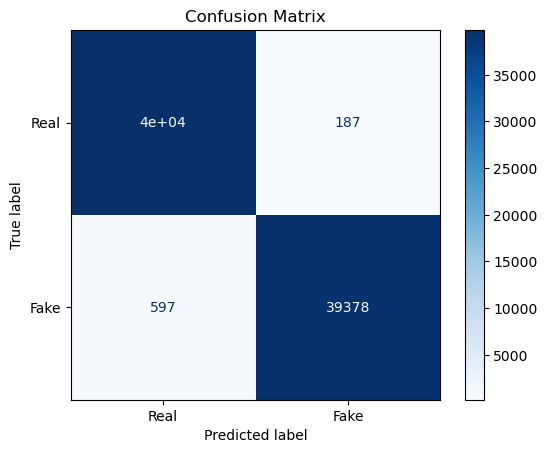

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


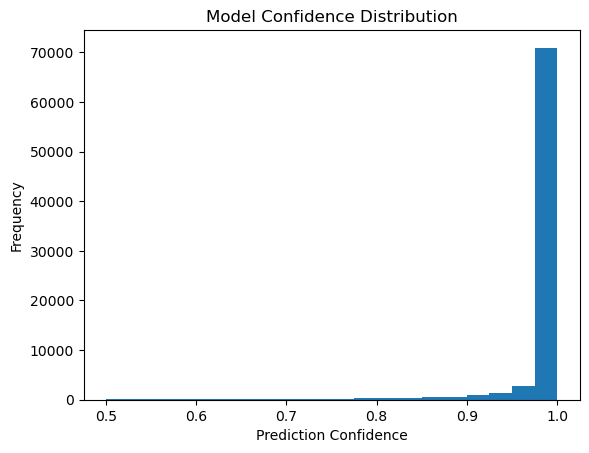

In [6]:
import torch.nn.functional as F

confidences = []

with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        max_probs = probs.max(dim=1)[0].cpu().numpy()
        confidences.extend(max_probs)

plt.hist(confidences, bins=20)
plt.xlabel("Prediction Confidence")
plt.ylabel("Frequency")
plt.title("Model Confidence Distribution")
plt.show()


Test on Unlabeled data

In [7]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform=None, root_dir='dataset'):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        rel_path = self.df.iloc[idx]['id']
        img_path = os.path.join(self.root_dir, rel_path)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, rel_path

# Load test set
test_dataset = TestDataset(csv_file='dataset/test.csv', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Predict
test_preds = []
model.eval()

with torch.no_grad():
    for images, paths in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for path, pred in zip(paths, preds.cpu().numpy()):
            test_preds.append((path, pred))

# Save to CSV
import pandas as pd
df_test_preds = pd.DataFrame(test_preds, columns=["file_name", "predicted_label"])
df_test_preds.to_csv("test_predictions.csv", index=False)
print("Predictions saved to test_predictions.csv")


Predictions saved to test_predictions.csv


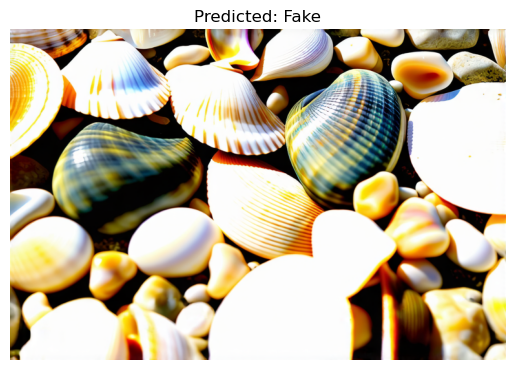

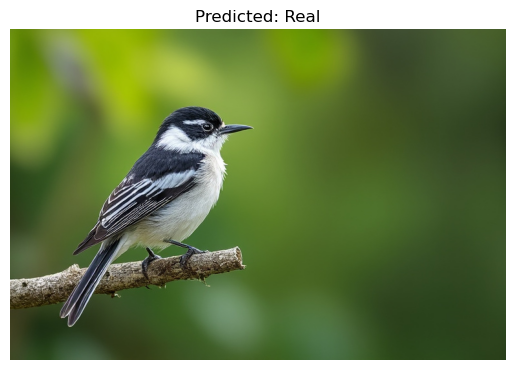

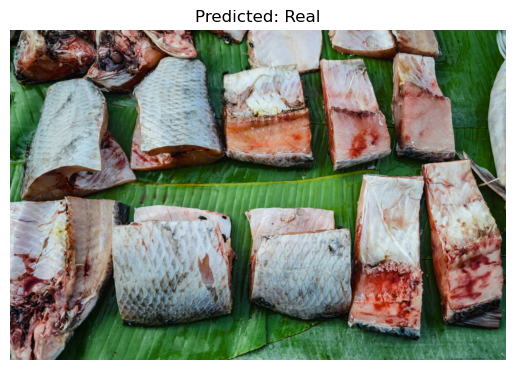

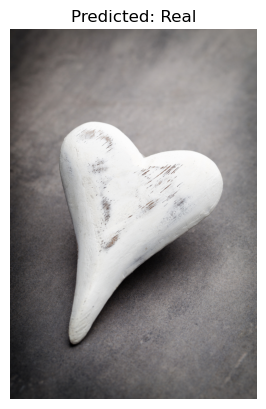

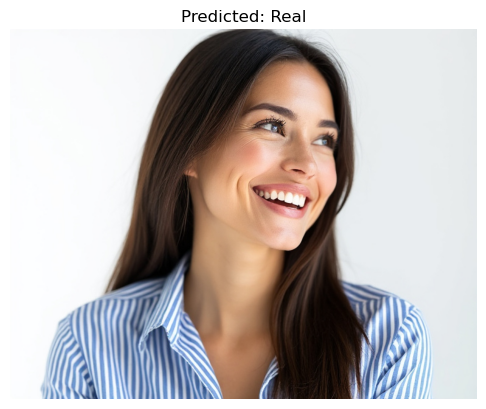

In [8]:
import matplotlib.pyplot as plt

sample = df_test_preds.sample(5)

for _, row in sample.iterrows():
    img_path = os.path.join("dataset", row["file_name"])
    label = row["predicted_label"]
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"Predicted: {'Fake' if label == 1 else 'Real'}")
    plt.axis("off")
    plt.show()


## DDP Implementation with Entire Dataset

In [1]:
%%writefile ddp_train.py

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.distributed import DistributedSampler
import pandas as pd
from PIL import Image
import time
from datetime import datetime

# --- Dataset ---
class TrainDataset(Dataset):
    def __init__(self, csv_file, transform=None, root_dir='dataset'):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row['file_name'])
        label = int(row['label'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# --- DDP Training Function ---
def main():
    dist.init_process_group("nccl")
    local_rank = int(os.environ["LOCAL_RANK"])
    torch.cuda.set_device(local_rank)
    device = torch.device("cuda", local_rank)

    # Transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    # Load full dataset
    dataset = TrainDataset("dataset/train.csv", transform=transform)
    sampler = DistributedSampler(dataset)
    dataloader = DataLoader(dataset, batch_size=64, sampler=sampler, num_workers=2)

    # Model
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 2)
    model.to(device)
    model = DDP(model, device_ids=[local_rank])

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # --- Start Benchmarking ---
    if local_rank == 0:
        torch.cuda.reset_peak_memory_stats()
        start = time.time()

    for epoch in range(3): 
        model.train()
        sampler.set_epoch(epoch)
        total_loss, correct, total = 0, 0, 0

        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        if local_rank == 0:
            acc = correct / total
            print(f"[GPU {local_rank}] Epoch {epoch+1} | Loss: {total_loss/total:.4f} | Acc: {acc:.4f}")

    # --- End Benchmarking ---
    if local_rank == 0:
        end = time.time()
        duration = end - start
        mem = torch.cuda.max_memory_allocated() / 1e9
        print("\n--- Benchmark (DDP) ---")
        print(f"Time: {duration:.2f} s")
        print(f"Accuracy: {acc:.4f}")
        print(f"Max GPU Memory: {mem:.2f} GB")

        with open("benchmark_log.txt", "a") as f:
            f.write(f"[{datetime.now()}] DDP (No AMP) ({dist.get_world_size()} GPUs)\n")
            f.write(f"Time: {duration:.2f}s | Acc: {acc:.4f} | Mem: {mem:.2f} GB\n\n")

    if local_rank == 0:
        torch.save(model.module.state_dict(), "ddp_model.pth")
        print("Model saved to ddp_model.pth")

if __name__ == "__main__":
    main()

Overwriting ddp_train.py


In [2]:
!torchrun --nproc-per-node=1 ddp_train.py

/home/deodhar.ad/.conda/envs/py2024/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[GPU 0] Epoch 1 | Loss: 0.0437 | Acc: 0.9827
[GPU 0] Epoch 2 | Loss: 0.0123 | Acc: 0.9958

--- Benchmark (DDP) ---
Time: 1673.33 s
Accuracy: 0.9958
Max GPU Memory: 1.74 GB
Model saved to ddp_model.pth
[rank0]:[W413 21:22:02.557961231 ProcessGroupNCCL.cpp:1250] Warning: WARNING: process group has NOT been destroyed before we destruct ProcessGroupNCCL. On normal program exit, the application should call destroy_process_group to ensure that any pending NCCL operations have finished in this process. In rare cases this 

In [3]:
!torchrun --nproc-per-node=2 ddp_train.py

W0413 21:22:07.932000 3018800 site-packages/torch/distributed/run.py:793] 
W0413 21:22:07.932000 3018800 site-packages/torch/distributed/run.py:793] *****************************************
W0413 21:22:07.932000 3018800 site-packages/torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0413 21:22:07.932000 3018800 site-packages/torch/distributed/run.py:793] *****************************************
/home/deodhar.ad/.conda/envs/py2024/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker nu

In [4]:
!torchrun --nproc-per-node=4 ddp_train.py

W0413 21:50:45.202000 3019173 site-packages/torch/distributed/run.py:793] 
W0413 21:50:45.202000 3019173 site-packages/torch/distributed/run.py:793] *****************************************
W0413 21:50:45.202000 3019173 site-packages/torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0413 21:50:45.202000 3019173 site-packages/torch/distributed/run.py:793] *****************************************
/home/deodhar.ad/.conda/envs/py2024/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker nu

In [2]:
import torch
from torchvision.models import resnet18
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model architecture
model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 2)

# Load trained weights
model.load_state_dict(torch.load("ddp_model.pth", map_location=device))
model.to(device)
model.eval()

/tmp/ipykernel_2245616/4011891912.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ddp_model.pth", map_location=device))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import os

# Dataset (same as training)
class TrainDataset(Dataset):
    def __init__(self, csv_file, transform=None, root_dir='dataset'):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row['file_name'])
        label = int(row['label'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load full dataset for validation
val_dataset = TrainDataset(csv_file="dataset/train.csv", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)


In [4]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy
print("Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=["Real", "Fake"]))


Accuracy: 0.9989493433395873
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00     39975
        Fake       1.00      1.00      1.00     39975

    accuracy                           1.00     79950
   macro avg       1.00      1.00      1.00     79950
weighted avg       1.00      1.00      1.00     79950



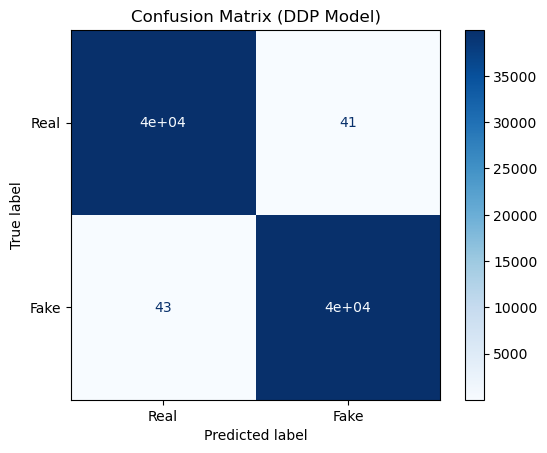

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (DDP Model)")
plt.show()


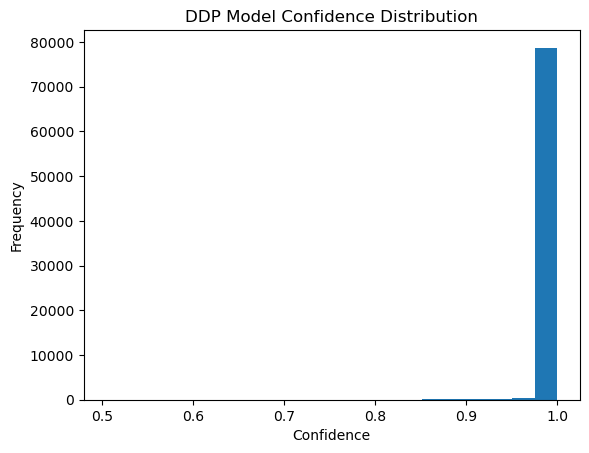

In [6]:
import torch.nn.functional as F

confidences = []

with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        max_probs = probs.max(dim=1)[0].cpu().numpy()
        confidences.extend(max_probs)

plt.hist(confidences, bins=20)
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.title("DDP Model Confidence Distribution")
plt.show()

testing in unlabeled data

In [7]:
import torch
from torchvision.models import resnet18
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("ddp_model.pth", map_location=device))
model.to(device)
model.eval()


/tmp/ipykernel_2245616/3696465639.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ddp_model.pth", map_location=device))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

class TestDataset(Dataset):
    def __init__(self, csv_file, transform=None, root_dir='dataset'):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        rel_path = self.df.iloc[idx]['id']  # 'id' column = relative file path
        img_path = os.path.join(self.root_dir, rel_path)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, rel_path  # return path so we can link prediction to filename


In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_dataset = TestDataset(csv_file="dataset/test.csv", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


In [10]:
test_preds = []

with torch.no_grad():
    for images, paths in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for path, pred in zip(paths, preds.cpu().numpy()):
            test_preds.append((path, pred))

# Save predictions to CSV
df_preds = pd.DataFrame(test_preds, columns=["file_name", "predicted_label"])
df_preds.to_csv("test_predictions_ddp.csv", index=False)
print("Test predictions saved to test_predictions_ddp.csv")


Test predictions saved to test_predictions_ddp.csv


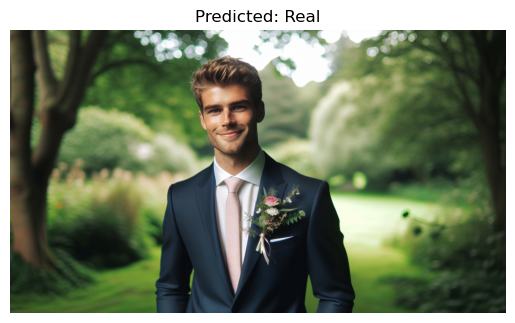

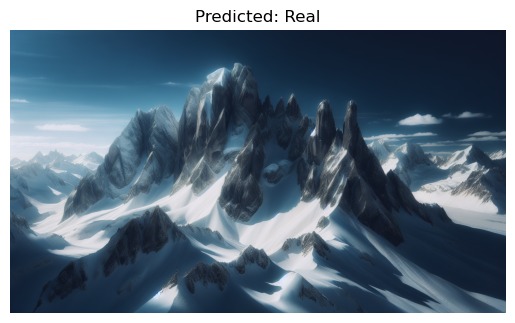

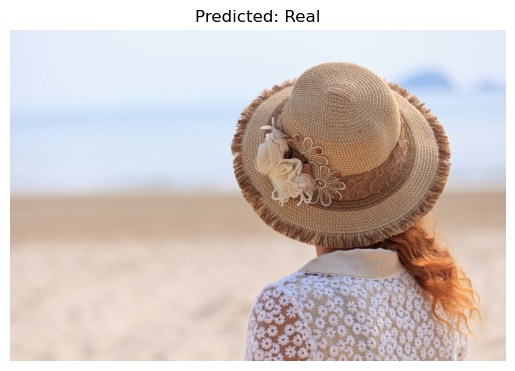

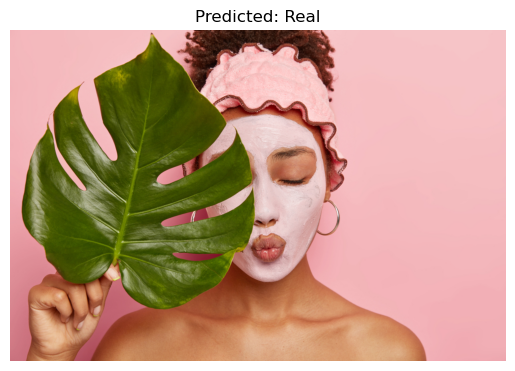

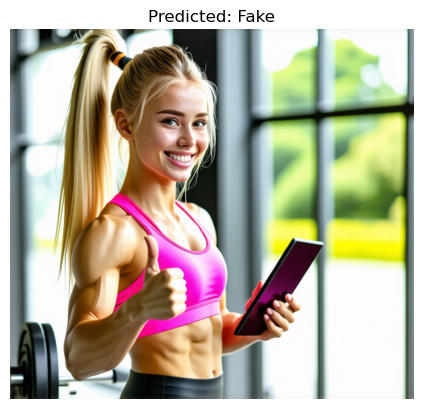

In [11]:
import matplotlib.pyplot as plt

sample = df_preds.sample(5)

for _, row in sample.iterrows():
    img_path = os.path.join("dataset", row["file_name"])
    label = row["predicted_label"]
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"Predicted: {'Fake' if label == 1 else 'Real'}")
    plt.axis("off")
    plt.show()


## DDP with Mixed Precision Training (AMP)

In [1]:
%%writefile ddp_amp_train.py

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.distributed import DistributedSampler
from torch.cuda.amp import autocast, GradScaler
from PIL import Image
import pandas as pd

# --- Dataset ---
class TrainDataset(Dataset):
    def __init__(self, csv_file, transform=None, root_dir='dataset'):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row['file_name'])
        label = int(row['label'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# --- DDP Training Function with AMP ---
def main():
    dist.init_process_group("nccl")
    local_rank = int(os.environ["LOCAL_RANK"])
    torch.cuda.set_device(local_rank)
    device = torch.device("cuda", local_rank)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    dataset = TrainDataset("dataset/train.csv", transform=transform)
    sampler = DistributedSampler(dataset)
    dataloader = DataLoader(dataset, batch_size=64, sampler=sampler, num_workers=2)

    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 2)
    model.to(device)
    model = DDP(model, device_ids=[local_rank])

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scaler = GradScaler()

    for epoch in range(3):  # You can increase this
        model.train()
        sampler.set_epoch(epoch)
        total_loss, correct, total = 0, 0, 0

        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item() * labels.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        print(f"[GPU {local_rank}] Epoch {epoch+1} | Loss: {total_loss/total:.4f} | Acc: {acc:.4f}")

    if local_rank == 0:
        torch.save(model.module.state_dict(), "ddp_amp_model.pth")
        print("AMP model saved to ddp_amp_model.pth")

if __name__ == "__main__":
    main()

Overwriting ddp_amp_train.py


In [2]:
import torch
from torchvision.models import resnet18
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("ddp_amp_model.pth", map_location=device))
model.to(device)
model.eval()

/tmp/ipykernel_3748813/4118008969.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ddp_amp_model.pth", map_location=device))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

class TrainDataset(Dataset):
    def __init__(self, csv_file, transform=None, root_dir='dataset'):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row['file_name'])
        label = int(row['label'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_dataset = TrainDataset("dataset/train.csv", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)


In [4]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=["Real", "Fake"]))


Accuracy: 0.9990494058786742
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00     39975
        Fake       1.00      1.00      1.00     39975

    accuracy                           1.00     79950
   macro avg       1.00      1.00      1.00     79950
weighted avg       1.00      1.00      1.00     79950



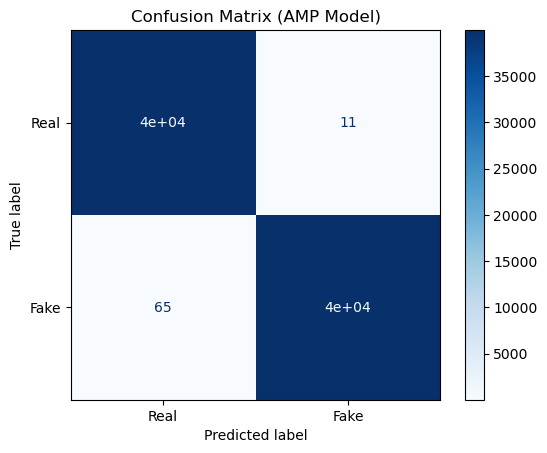

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (AMP Model)")
plt.show()

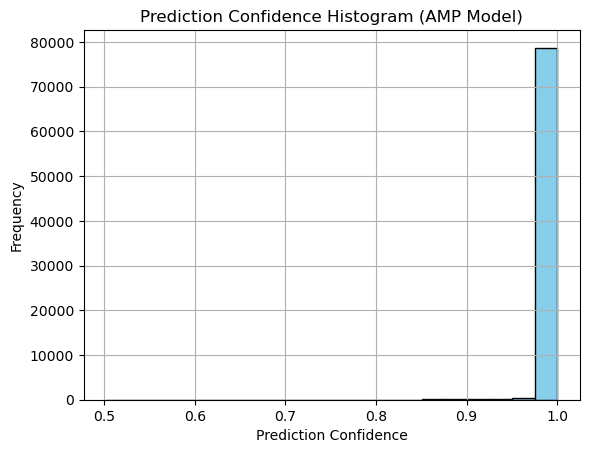

In [6]:
import torch.nn.functional as F

confidences = []

with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        max_probs = probs.max(dim=1)[0].cpu().numpy()
        confidences.extend(max_probs)

plt.hist(confidences, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Prediction Confidence")
plt.ylabel("Frequency")
plt.title("Prediction Confidence Histogram (AMP Model)")
plt.grid(True)
plt.show()

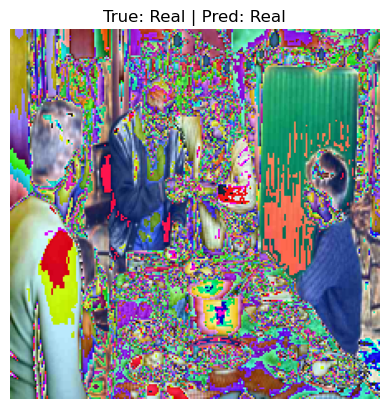

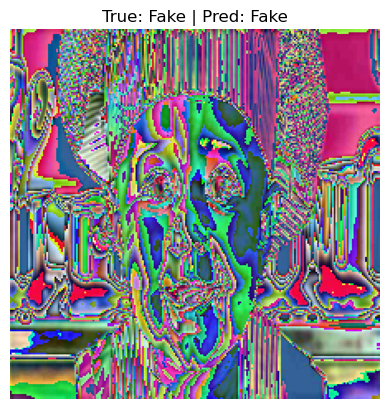

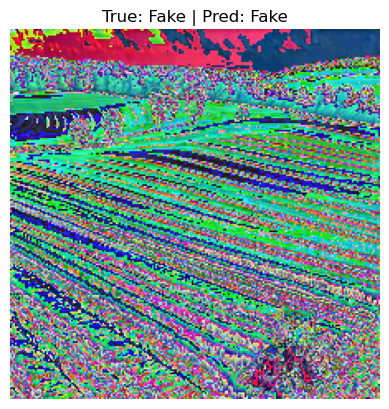

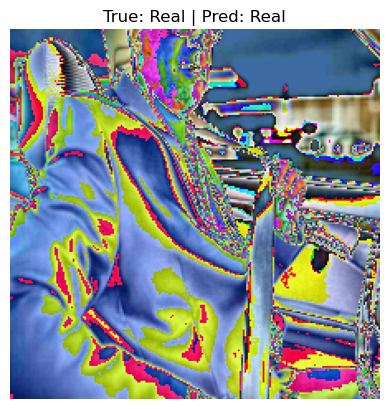

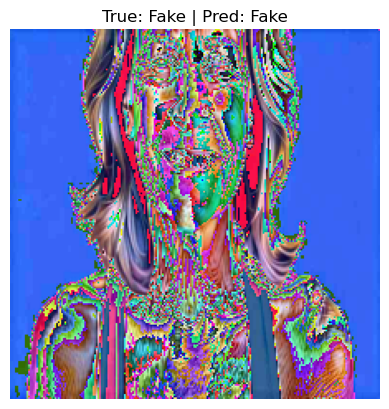

In [7]:
import random
from PIL import Image

sample_idx = random.sample(range(len(val_dataset)), 5)

for idx in sample_idx:
    img, label = val_dataset[idx]
    img_disp = transforms.ToPILImage()(img.cpu())
    img_input = img.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(img_input).argmax(dim=1).item()

    plt.imshow(img_disp)
    plt.title(f"True: {'Fake' if label==1 else 'Real'} | Pred: {'Fake' if pred==1 else 'Real'}")
    plt.axis("off")
    plt.show()


## Model Parallelism 

In [8]:
%%writefile model_parallel_train.py

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import resnet18
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
import time

# --- Dataset ---
class TrainDataset(Dataset):
    def __init__(self, csv_file, transform=None, root_dir='dataset'):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row['file_name'])
        label = int(row['label'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# --- Model Parallel ResNet ---
class ModelParallelResNet(nn.Module):
    def __init__(self):
        super().__init__()
        full_model = resnet18(weights=None)
        self.seq1 = nn.Sequential(*list(full_model.children())[:5]).to("cuda:0")
        self.seq2 = nn.Sequential(*list(full_model.children())[5:-1]).to("cuda:1")
        self.fc = nn.Linear(full_model.fc.in_features, 2).to("cuda:1")

    def forward(self, x):
        x = x.to("cuda:0")
        x = self.seq1(x)
        x = x.to("cuda:1")
        x = self.seq2(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# --- Main ---
def main():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    dataset = TrainDataset("dataset/train.csv", transform=transform)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

    model = ModelParallelResNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    print("Starting model-parallel training...")
    start_time = time.time()

    for epoch in range(3):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for images, labels in dataloader:
            labels = labels.to("cuda:1")  # output on GPU 1
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        print(f"Epoch {epoch+1} | Loss: {total_loss/total:.4f} | Acc: {acc:.4f}")

    torch.save(model.state_dict(), "model_parallel_resnet.pth")
    print(f"Done. Model saved. Time: {time.time() - start_time:.2f}s")

if __name__ == "__main__":
    main()

Writing model_parallel_train.py


In [9]:
import torch
import torch.nn as nn
from torchvision.models import resnet18

# Define the same split model architecture
class ModelParallelResNet(nn.Module):
    def __init__(self):
        super().__init__()
        full_model = resnet18(weights=None)
        self.seq1 = nn.Sequential(*list(full_model.children())[:5]).to("cuda:0")
        self.seq2 = nn.Sequential(*list(full_model.children())[5:-1]).to("cuda:1")
        self.fc = nn.Linear(full_model.fc.in_features, 2).to("cuda:1")

    def forward(self, x):
        x = x.to("cuda:0")
        x = self.seq1(x)
        x = x.to("cuda:1")
        x = self.seq2(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

device = torch.device("cuda:1")
model = ModelParallelResNet()
model.load_state_dict(torch.load("model_parallel_resnet.pth", map_location="cuda:1"))
model.eval()

/tmp/ipykernel_3748813/3688657868.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_parallel_resnet.pth", map_location="cuda:1"))


ModelParallelResNet(
  (seq1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [10]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os

class TrainDataset(Dataset):
    def __init__(self, csv_file, transform=None, root_dir='dataset'):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row['file_name'])
        label = int(row['label'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_dataset = TrainDataset("dataset/train.csv", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

In [11]:
from sklearn.metrics import accuracy_score, classification_report

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to("cuda:0")  # forward pass starts on GPU 0
        labels = labels.to("cuda:1")  # model output is on GPU 1
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=["Real", "Fake"]))

Accuracy: 0.9875171982489056
              precision    recall  f1-score   support

        Real       0.99      0.98      0.99     39975
        Fake       0.98      0.99      0.99     39975

    accuracy                           0.99     79950
   macro avg       0.99      0.99      0.99     79950
weighted avg       0.99      0.99      0.99     79950



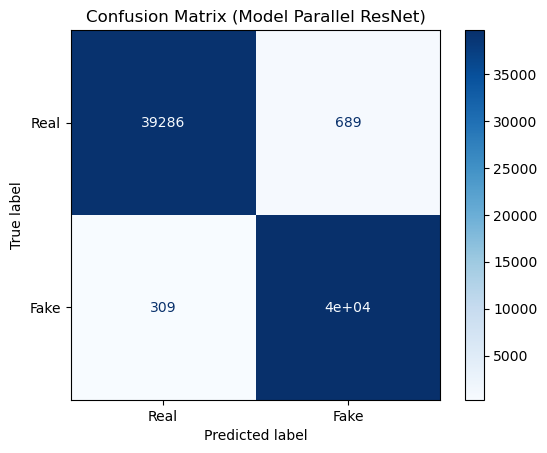

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Model Parallel ResNet)")
plt.show()

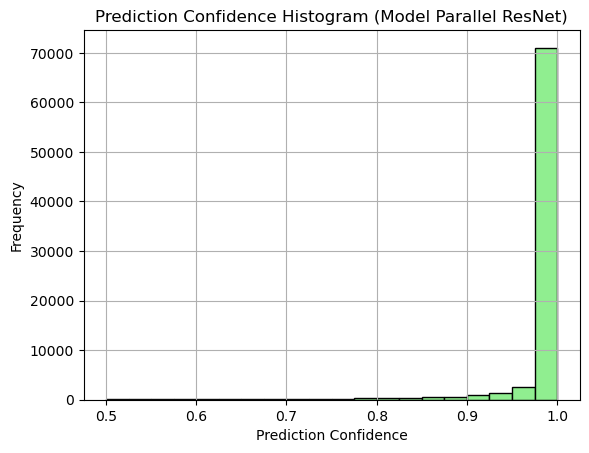

In [13]:
import torch.nn.functional as F

confidences = []

with torch.no_grad():
    for images, _ in val_loader:
        images = images.to("cuda:0")
        outputs = model(images.to("cuda:0"))
        probs = F.softmax(outputs.to("cuda:1"), dim=1)
        max_probs = probs.max(dim=1)[0].cpu().numpy()
        confidences.extend(max_probs)

plt.hist(confidences, bins=20, color='lightgreen', edgecolor='black')
plt.xlabel("Prediction Confidence")
plt.ylabel("Frequency")
plt.title("Prediction Confidence Histogram (Model Parallel ResNet)")
plt.grid(True)
plt.show()

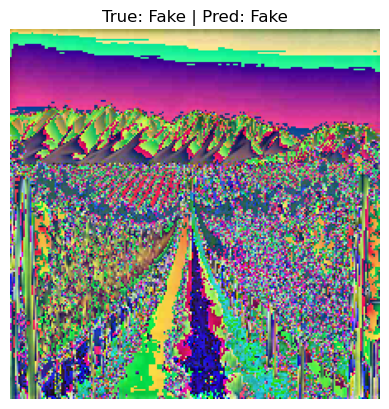

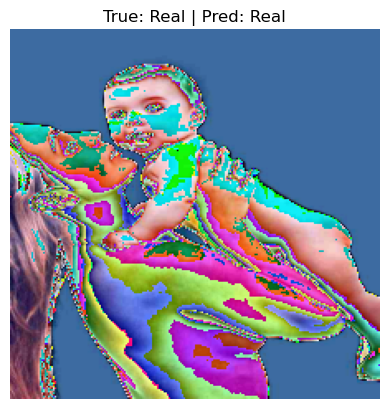

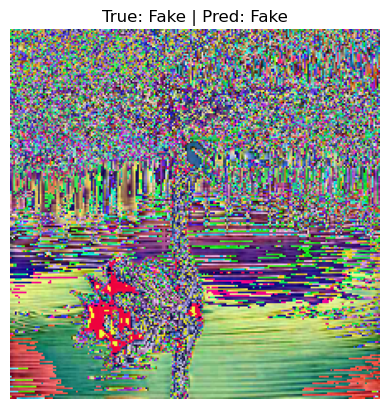

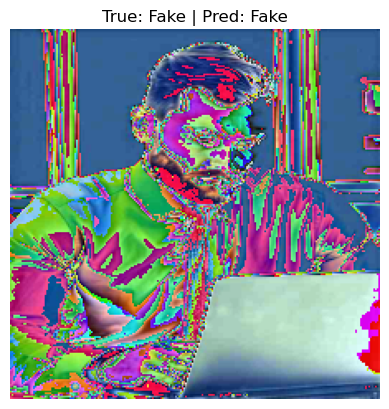

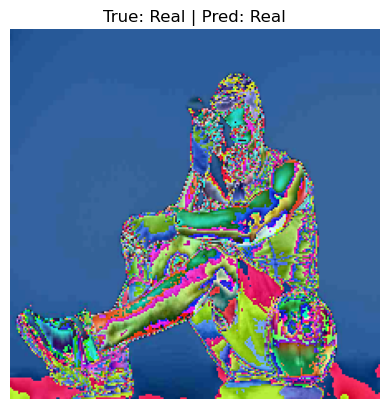

In [14]:
import random
from PIL import Image

sample_idx = random.sample(range(len(val_dataset)), 5)

for idx in sample_idx:
    img, label = val_dataset[idx]
    img_disp = transforms.ToPILImage()(img.cpu())
    img_input = img.unsqueeze(0).to("cuda:0")

    with torch.no_grad():
        output = model(img_input)
        pred = output.argmax(dim=1).item()

    plt.imshow(img_disp)
    plt.title(f"True: {'Fake' if label==1 else 'Real'} | Pred: {'Fake' if pred==1 else 'Real'}")
    plt.axis("off")
    plt.show()

## Benchmarking for all models

### 1. DDP

In [2]:
# ---------------------- Imports ----------------------
import os
import torch
import torch.nn as nn
import time
import pandas as pd
from torchvision.models import resnet18
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from PIL import Image
from datetime import datetime

# ---------------------- Dataset ----------------------
class TrainDataset(Dataset):
    def __init__(self, csv_file, transform=None, root_dir='dataset'):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row['file_name'])
        label = int(row['label'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# ---------------------- Transforms + Dataloader ----------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_dataset = TrainDataset("dataset/train.csv", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

# ---------------------- Load Model ----------------------
model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("ddp_model.pth", map_location="cuda"))
model = model.to("cuda").eval()

# ---------------------- Evaluation & Benchmarking ----------------------
torch.cuda.reset_peak_memory_stats()
start = time.time()

all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to("cuda"), y.to("cuda")
        out = model(x)
        all_preds.extend(out.argmax(1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

end = time.time()
acc = accuracy_score(all_labels, all_preds)
mem = torch.cuda.max_memory_allocated() / 1e9

# ---------------------- Results ----------------------
print("Benchmark: DDP (No AMP)")
print(f"Time: {end-start:.2f} s")
print(f"Accuracy: {acc:.4f}")
print(f"Max GPU Memory: {mem:.2f} GB")
print(f"AMP: No | GPUs Used: 2")

# Optional logging
with open("benchmark_log.txt", "a") as f:
    f.write(f"[{datetime.now()}] DDP (No AMP)\n")
    f.write(f"Time: {end-start:.2f}s | Acc: {acc:.4f} | Mem: {mem:.2f} GB\n\n")

/tmp/ipykernel_3881729/2008434663.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ddp_model.pth", map_location="cuda"))


Benchmark: DDP (No AMP)
Time: 805.74 s
Accuracy: 0.9993
Max GPU Memory: 0.50 GB
AMP: No | GPUs Used: 2


### 2. DDP with AMP

In [2]:
# ---------------------- Imports ----------------------
import os
import torch
import torch.nn as nn
import time
import pandas as pd
from torchvision.models import resnet18
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from PIL import Image
from datetime import datetime

# ---------------------- Dataset ----------------------
class TrainDataset(Dataset):
    def __init__(self, csv_file, transform=None, root_dir='dataset'):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row['file_name'])
        label = int(row['label'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# ---------------------- Transforms + Dataloader ----------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_dataset = TrainDataset("dataset/train.csv", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

# ---------------------- Load Model ----------------------
model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("ddp_amp_model.pth", map_location="cuda"))
model = model.to("cuda").eval()

# ---------------------- Evaluation & Benchmarking ----------------------
from torch.cuda.amp import autocast

torch.cuda.reset_peak_memory_stats()
start = time.time()

all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to("cuda"), y.to("cuda")
        with autocast():
            out = model(x)
        all_preds.extend(out.argmax(1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

end = time.time()
acc = accuracy_score(all_labels, all_preds)
mem = torch.cuda.max_memory_allocated() / 1e9

# ---------------------- Results ----------------------
print("Benchmark: DDP + AMP")
print(f"Time: {end-start:.2f} s")
print(f"Accuracy: {acc:.4f}")
print(f"Max GPU Memory: {mem:.2f} GB")
print(f"AMP: Yes | GPUs Used: 2")

with open("benchmark_log.txt", "a") as f:
    f.write(f"[{datetime.now()}] DDP + AMP\n")
    f.write(f"Time: {end-start:.2f}s | Acc: {acc:.4f} | Mem: {mem:.2f} GB\n\n")

/tmp/ipykernel_1942160/950735534.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ddp_amp_model.pth", map_location="cuda"))
/tmp/ipyker

Benchmark: DDP + AMP
Time: 1070.11 s
Accuracy: 0.9990
Max GPU Memory: 0.34 GB
AMP: Yes | GPUs Used: 2


### 3. Model Parallel

In [4]:
# ---------------------- Imports ----------------------
import os
import torch
import torch.nn as nn
import time
import pandas as pd
from torchvision.models import resnet18
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from PIL import Image
from datetime import datetime

# ---------------------- Dataset ----------------------
class TrainDataset(Dataset):
    def __init__(self, csv_file, transform=None, root_dir='dataset'):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row['file_name'])
        label = int(row['label'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# ---------------------- Transforms + Dataloader ----------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_dataset = TrainDataset("dataset/train.csv", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

# ---------------------- Model Parallel Architecture ----------------------
class ModelParallelResNet(nn.Module):
    def __init__(self):
        super().__init__()
        base = resnet18(weights=None)
        self.seq1 = nn.Sequential(*list(base.children())[:5]).to("cuda:0")
        self.seq2 = nn.Sequential(*list(base.children())[5:-1]).to("cuda:1")
        self.fc = nn.Linear(base.fc.in_features, 2).to("cuda:1")

    def forward(self, x):
        x = x.to("cuda:0")
        x = self.seq1(x)
        x = x.to("cuda:1")
        x = self.seq2(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = ModelParallelResNet()
model.load_state_dict(torch.load("model_parallel_resnet.pth"))
model.eval()

# ---------------------- Evaluation & Benchmarking ----------------------
torch.cuda.reset_peak_memory_stats()
start = time.time()

all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in val_loader:
        x = x.to("cuda:0")
        y = y.to("cuda:1")
        out = model(x)
        all_preds.extend(out.argmax(1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

end = time.time()
acc = accuracy_score(all_labels, all_preds)
mem = torch.cuda.max_memory_allocated() / 1e9

# ---------------------- Results ----------------------
print("Benchmark: Model Parallel")
print(f"Time: {end-start:.2f} s")
print(f"Accuracy: {acc:.4f}")
print(f"Max GPU Memory: {mem:.2f} GB")
print(f"AMP: No | GPUs Used: 2 (manual split)")

with open("benchmark_log.txt", "a") as f:
    f.write(f"[{datetime.now()}] Model Parallel\n")
    f.write(f"Time: {end-start:.2f}s | Acc: {acc:.4f} | Mem: {mem:.2f} GB\n\n")


/tmp/ipykernel_2994207/2166041053.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_parallel_resnet.pth"))


Benchmark: Model Parallel
Time: 741.73 s
Accuracy: 0.9875
Max GPU Memory: 0.46 GB
AMP: No | GPUs Used: 2 (manual split)


## Single GPU (Serial) on all data + Benchmarking

In [5]:
%%writefile single_gpu_train.py

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import resnet18
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import time

# Dataset
class TrainDataset(Dataset):
    def __init__(self, csv_file, transform=None, root_dir='dataset'):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row['file_name'])
        label = int(row['label'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    dataset = TrainDataset("dataset/train.csv", transform=transform)
    loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

    model = resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 2)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    print("Starting single-GPU training...")
    for epoch in range(3):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * y.size(0)
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

        acc = correct / total
        print(f"Epoch {epoch+1} | Loss: {total_loss/total:.4f} | Acc: {acc:.4f}")

    torch.save(model.state_dict(), "single_gpu_model.pth")
    print("Model saved as single_gpu_model.pth")

if __name__ == "__main__":
    main()

Writing single_gpu_train.py


In [6]:
!python single_gpu_train.py

/home/deodhar.ad/.conda/envs/py2024/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Starting single-GPU training...
Epoch 1 | Loss: 0.1696 | Acc: 0.9348
Epoch 2 | Loss: 0.0696 | Acc: 0.9746
Epoch 3 | Loss: 0.0530 | Acc: 0.9809
Model saved as single_gpu_model.pth


In [7]:
import os, torch, time
import torch.nn as nn
import pandas as pd
from torchvision.models import resnet18
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import accuracy_score
from datetime import datetime

# Dataset
class TrainDataset(Dataset):
    def __init__(self, csv_file, transform=None, root_dir='dataset'):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row['file_name'])
        label = int(row['label'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Loader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
val_dataset = TrainDataset("dataset/train.csv", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

# Load model
model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("single_gpu_model.pth", map_location="cuda"))
model = model.to("cuda").eval()

torch.cuda.reset_peak_memory_stats()
start = time.time()

# Evaluate
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to("cuda"), y.to("cuda")
        out = model(x)
        all_preds.extend(out.argmax(1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

end = time.time()
acc = accuracy_score(all_labels, all_preds)
mem = torch.cuda.max_memory_allocated() / 1e9

print("Benchmark: Single GPU (No AMP)")
print(f"Time: {end-start:.2f} s")
print(f"Accuracy: {acc:.4f}")
print(f"Max GPU Memory: {mem:.2f} GB")
print(f"AMP: No | GPUs Used: 1")

with open("benchmark_log.txt", "a") as f:
    f.write(f"[{datetime.now()}] Single GPU (No AMP)\n")
    f.write(f"Time: {end-start:.2f}s | Acc: {acc:.4f} | Mem: {mem:.2f} GB\n\n")


/tmp/ipykernel_2994207/2969903190.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("single_gpu_model.pth", map_location="cuda"))


Benchmark: Single GPU (No AMP)
Time: 743.45 s
Accuracy: 0.9858
Max GPU Memory: 0.50 GB
AMP: No | GPUs Used: 1


## Computing on CPUs (1, 2, and 4) + Benchmarking

In [1]:
%%writefile cpu_train.py

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import resnet18
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import pandas as pd
import time
import random
from datetime import datetime
from sklearn.metrics import accuracy_score

class TrainDataset(Dataset):
    def __init__(self, csv_file, transform=None, root_dir='dataset'):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row['file_name'])
        label = int(row['label'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

def train_cpu(num_threads=1):
    torch.set_num_threads(num_threads)
    device = torch.device("cpu")

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    full_dataset = TrainDataset("dataset/train.csv", transform=transform)
    total_len = len(full_dataset)
    half_indices = random.sample(range(total_len), total_len // 4)
    dataset = Subset(full_dataset, half_indices)

    loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

    model = resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 2)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    print(f"\nTraining on CPU with {num_threads} threads (25% data)")

    start = time.time()
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    end = time.time()

    acc = correct / total
    duration = end - start

    model_path = f"cpu_model_{num_threads}threads.pth"
    torch.save(model.state_dict(), model_path)

    print(f"Accuracy: {acc:.4f}")
    print(f"Time: {duration:.2f}s")
    print(f"Model saved as {model_path}")

    with open("benchmark_log.txt", "a") as f:
        f.write(f"[{datetime.now()}] CPU-{num_threads} Threads\n")
        f.write(f"Time: {duration:.2f}s | Acc: {acc:.4f} | AMP: No | Dataset: 25%\n\n")

if __name__ == "__main__":
    for t in [1, 2, 4]:
        train_cpu(num_threads=t)

Overwriting cpu_train.py


In [2]:
!python cpu_train.py

/home/deodhar.ad/.conda/envs/py2024/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(

Training on CPU with 1 threads (25% data)
Accuracy: 0.8997
Time: 2831.56s
Model saved as cpu_model_1threads.pth
/home/deodhar.ad/.conda/envs/py2024/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker 

## Plotting the comparisons

/tmp/ipykernel_1945387/1105355838.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='method', y='scaled_time', data=ddp_compare, palette="Blues_d")


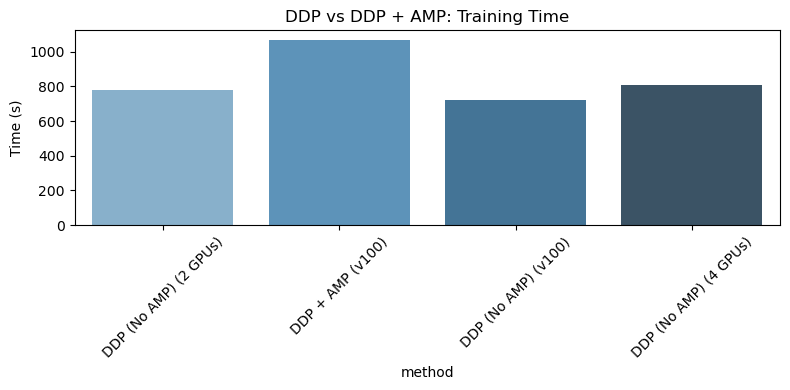

/tmp/ipykernel_1945387/1105355838.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='method', y='accuracy', data=ddp_compare, palette="Greens_d")


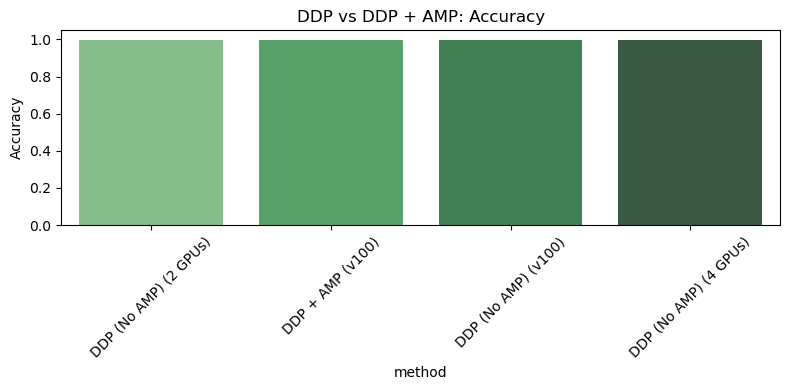

/tmp/ipykernel_1945387/1105355838.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpu_df['threads'] = cpu_df['method'].str.extract(r'(\d+)').astype(int)


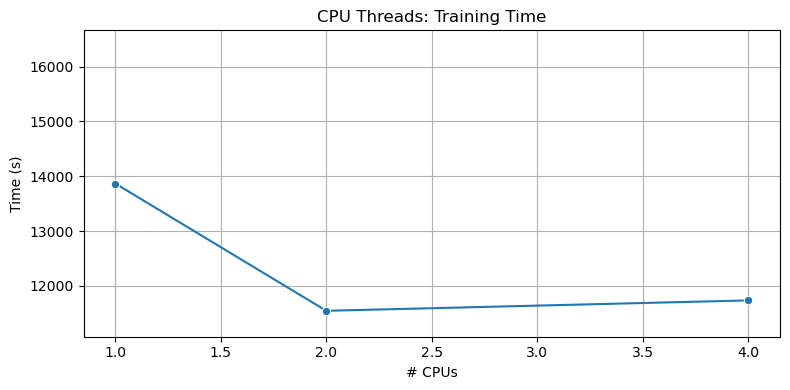

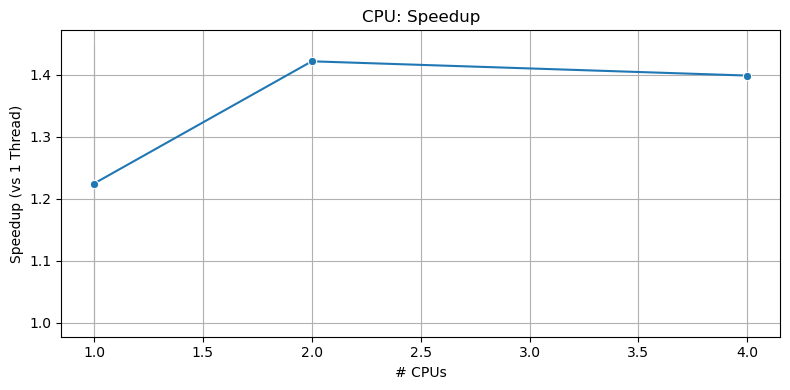

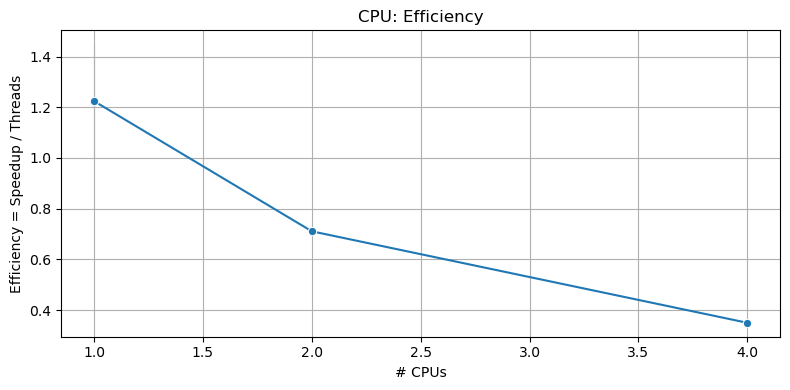

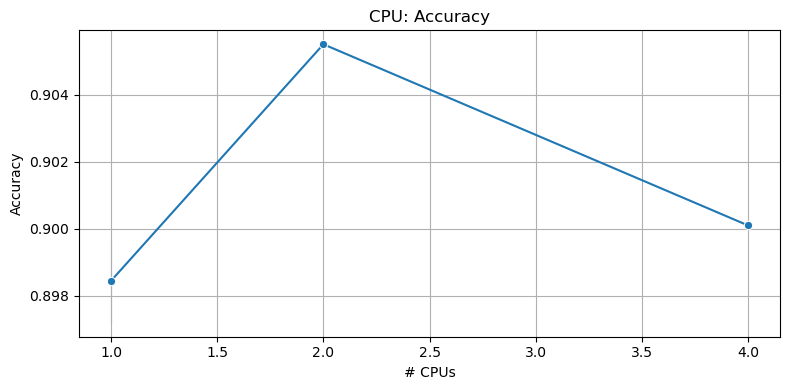

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# --- Load and Parse benchmark_log.txt ---
with open("benchmark_log.txt", "r") as f:
    lines = [line.strip() for line in f if line.strip()]

entries = []
for i in range(0, len(lines), 2):
    method_line = lines[i]
    data_line = lines[i+1]

    method = re.sub(r"\[.*\]\s*", "", method_line).strip()
    time = float(re.search(r"Time: ([\d.]+)s", data_line).group(1))
    acc = float(re.search(r"Acc: ([\d.]+)", data_line).group(1))
    mem_match = re.search(r"Mem: ([\d.]+)", data_line)
    mem = float(mem_match.group(1)) if mem_match else None
    dataset = re.search(r"Dataset: (\d+%)", data_line)
    dataset_size = dataset.group(1) if dataset else "100%"

    entries.append({
        "method": method,
        "time": time,
        "accuracy": acc,
        "memory": mem,
        "dataset": dataset_size
    })

df = pd.DataFrame(entries)
df['scaled_time'] = df.apply(lambda row: row['time'] * 4 if 'CPU' in row['method'] and row['dataset'] == '25%' else row['time'], axis=1)

# === GROUP 1: DDP vs DDP + AMP ===
ddp_amp_df = df[df['method'].str.contains("DDP") & df['method'].str.contains("AMP")]
ddp_base_df = df[df['method'] == "DDP (No AMP)"]

ddp_compare = pd.concat([ddp_base_df, ddp_amp_df])
plt.figure(figsize=(8, 4))
sns.barplot(x='method', y='scaled_time', data=ddp_compare, palette="Blues_d")
plt.title("DDP vs DDP + AMP: Training Time")
plt.ylabel("Time (s)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(x='method', y='accuracy', data=ddp_compare, palette="Greens_d")
plt.title("DDP vs DDP + AMP: Accuracy")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === GROUP 2: DDP Multi-GPU Speedup & Accuracy ===
ddp_multi = df[df['method'].str.contains("DDP") & df['method'].str.contains("GPU")]
if not ddp_base_df.empty:
    ddp_baseline = ddp_base_df['scaled_time'].values[0]
    ddp_multi['gpus'] = ddp_multi['method'].str.extract(r'(\d+)').astype(float)
    ddp_multi['speedup'] = ddp_baseline / ddp_multi['scaled_time']
    ddp_multi['efficiency'] = ddp_multi['speedup'] / ddp_multi['gpus']

    plt.figure(figsize=(8, 4))
    sns.lineplot(x='gpus', y='scaled_time', data=ddp_multi, marker="o")
    plt.title("DDP Multi-GPU: Training Time")
    plt.ylabel("Time (s)")
    plt.xlabel("# GPUs")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    sns.lineplot(x='gpus', y='speedup', data=ddp_multi, marker="o")
    plt.title("DDP Multi-GPU: Speedup vs Baseline")
    plt.ylabel("Speedup")
    plt.xlabel("# GPUs")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    sns.lineplot(x='gpus', y='efficiency', data=ddp_multi, marker="o")
    plt.title("DDP Multi-GPU: Efficiency")
    plt.ylabel("Efficiency = Speedup / GPUs")
    plt.xlabel("# GPUs")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    sns.lineplot(x='gpus', y='accuracy', data=ddp_multi, marker="o")
    plt.title("DDP Multi-GPU: Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("# GPUs")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === GROUP 3: CPU 1/2/4 Threads ===
cpu_df = df[df['method'].str.contains("CPU")]
cpu_df['threads'] = cpu_df['method'].str.extract(r'(\d+)').astype(int)
cpu_df = cpu_df.sort_values('threads')
baseline_cpu = cpu_df[cpu_df['threads'] == 1]['scaled_time'].values[0]
cpu_df['speedup'] = baseline_cpu / cpu_df['scaled_time']
cpu_df['efficiency'] = cpu_df['speedup'] / cpu_df['threads']

plt.figure(figsize=(8, 4))
sns.lineplot(x='cpus', y='scaled_time', data=cpu_df, marker="o")
plt.title("CPU Threads: Training Time")
plt.ylabel("Time (s)")
plt.xlabel("# CPUs")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.lineplot(x='threads', y='speedup', data=cpu_df, marker="o")
plt.title("CPU: Speedup")
plt.ylabel("Speedup (vs 1 Thread)")
plt.xlabel("# CPUs")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.lineplot(x='threads', y='efficiency', data=cpu_df, marker="o")
plt.title("CPU: Efficiency")
plt.ylabel("Efficiency = Speedup / Threads")
plt.xlabel("# CPUs")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.lineplot(x='threads', y='accuracy', data=cpu_df, marker="o")
plt.title("CPU: Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("# CPUs")
plt.grid(True)
plt.tight_layout()
plt.show()
